## 一、背景
英雄联盟（League of Legends，LoL）是一个多人在线竞技游戏，由拳头游戏（Riot Games）公司出品。在游戏中，每位玩家控制一位有独特技能的英雄，红蓝两支队伍各有五位玩家进行对战，目标是摧毁对方的基地水晶。水晶有多座防御塔保护，通常需要先摧毁一些防御塔再摧毁水晶。玩家所控制的英雄起初非常弱，需要不断击杀小兵、野怪和对方英雄来获得金币、经验。经验可以提升英雄等级和技能等级，金币可以用来购买装备提升攻击、防御等属性。对战过程中一般没有己方单位在附近的地点是没有视野的，即无法看到对面单位，双方可以通过使用守卫来监视某个地点，洞察对面走向、制定战术。

本数据集来自[Kaggle](https://www.kaggle.com/bobbyscience/league-of-legends-diamond-ranked-games-10-min)，包含了9879场钻一到大师段位的单双排对局，对局双方几乎是同一水平。每条数据是前10分钟的对局情况，每支队伍有19个特征，红蓝双方共38个特征。这些特征包括英雄击杀、死亡，金钱、经验、等级情况等等。一局游戏一般会持续30至40分钟，但是实际前10分钟的局面很大程度上影响了之后胜负的走向。作为最成功的电子竞技游戏之一，对局数据、选手数据的量化与研究具有重要意义，可以启发游戏将来的发展和改进。

## 二、任务
使用决策树模型，根据已有的对局前10分钟特征信息，预测最后获胜方是蓝色方还是红色方。

## 三、评价指标
F1

## 四、模型训练

### 4.1 导入工具包

In [154]:
from collections import Counter
import pandas as pd                                                     # 数据处理
from ydata_profiling import ProfileReport                               # 自动化特征分析和生成报告
import numpy as np                                                      # 数学运算
from sklearn.model_selection import train_test_split, cross_validate    # 划分数据集函数
from sklearn.metrics import accuracy_score                              # 准确率函数
from sklearn.model_selection import GridSearchCV                        # 网格搜索
import matplotlib.pyplot as plt                                         # 绘制图形，如散点图、柱状图、饼图
import seaborn as sns                                                   # 热力图
from statsmodels.distributions.empirical_distribution import ECDF       # CDF
from scipy.integrate import quad                                        # 交并比和重叠系数
from sklearn.neighbors import KernelDensity                             # 核密度估计
RANDOM_SEED = 2023                                                      # 固定随机种子
import joblib                                                           # 模型保存加载
from tqdm import  tqdm                                                  # 任务进度

### 4.2 读入数据
假设数据文件放在`./data/`目录下。
1. 文件共有40列，38个特征（红蓝方各19），1个标签列（blueWins），和一个对局标号（gameId）。对局标号不是标签也不是特征，可以舍去。
2. 通过`.iloc[0]`取出数据的第一行并输出。不难看出每个特征都存成了float64浮点数，该对局蓝色方开局10分钟有小优势。
3. pandas的`describe()`函数，可以直接通过DataFrame进行调用，可以展示每一列数据的一些统计信息，对数据分布情况有大致了解，比如blueKills蓝色方击杀英雄数在前十分钟的平均数是6.14、方差为2.93，中位数是6，百分之五十以上的对局中该特征在4-8之间.
4. 也可以发现有些特征列是重复冗余的，比如blueGoldDiff表示蓝色队金币优势，redGoldDiff表示红色方金币优势，这两个特征是完全对称的互为相反数。blueCSPerMin是蓝色方每分钟击杀小兵数，它乘10就是10分钟所有小兵击杀数blueTotalMinionsKilled。在之后的特征处理过程中可以考虑去除这些冗余特征。

In [155]:
csv_data = './data/high_diamond_ranked_10min.csv'                       # 数据路径
data_df = pd.read_csv(csv_data, sep=',')                                # 读入csv文件为pandas的DataFrame
data_df = data_df.drop(columns='gameId')                                # 舍去对局标号列
print(data_df.iloc[0])                                                  # 输出第一行数据
data_df.describe()                                                      # 每列特征的简单统计信息

blueWins                            0.0
blueWardsPlaced                    28.0
blueWardsDestroyed                  2.0
blueFirstBlood                      1.0
blueKills                           9.0
blueDeaths                          6.0
blueAssists                        11.0
blueEliteMonsters                   0.0
blueDragons                         0.0
blueHeralds                         0.0
blueTowersDestroyed                 0.0
blueTotalGold                   17210.0
blueAvgLevel                        6.6
blueTotalExperience             17039.0
blueTotalMinionsKilled            195.0
blueTotalJungleMinionsKilled       36.0
blueGoldDiff                      643.0
blueExperienceDiff                 -8.0
blueCSPerMin                       19.5
blueGoldPerMin                   1721.0
redWardsPlaced                     15.0
redWardsDestroyed                   6.0
redFirstBlood                       0.0
redKills                            6.0
redDeaths                           9.0


,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
count,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,...,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000
mean,0.499038,22.288288,2.824881,0.504808,6.183925,6.137666,6.645106,0.549954,0.361980,0.187974,...,0.043021,16489.041401,6.925316,17961.730438,217.349226,51.313088,-14.414111,33.620306,21.734923,1648.904140
std,0.500024,18.019177,2.174998,0.500002,3.011028,2.933818,4.064520,0.625527,0.480597,0.390712,...,0.216900,1490.888406,0.305311,1198.583912,21.911668,10.027885,2453.349179,1920.370438,2.191167,149.088841
min,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,11212.000000,4.800000,10465.000000,107.000000,4.000000,-11467.000000,-8348.000000,10.700000,1121.200000
25%,0.000000,14.000000,1.000000,0.000000,4.000000,4.000000,4.000000,0.000000,0.000000,0.000000,...,0.000000,15427.500000,6.800000,17209.500000,203.000000,44.000000,-1596.000000,-1212.000000,20.300000,1542.750000
50%,0.000000,16.000000,3.000000,1.000000,6.000000,6.000000,6.000000,0.000000,0.000000,0.000000,...,0.000000,16378.000000,7.000000,17974.000000,218.000000,51.000000,-14.000000,28.000000,21.800000,1637.800000
75%,1.000000,20.000000,4.000000,1.000000,8.000000,8.000000,9.000000,1.000000,1.000000,0.000000,...,0.000000,17418.500000,7.200000,18764.500000,233.000000,57.000000,1585.500000,1290.500000,23.300000,1741.850000
max,1.000000,250.000000,27.000000,1.000000,22.000000,22.000000,29.000000,2.000000,1.000000,1.000000,...,2.000000,22732.000000,8.200000,22269.000000,289.000000,92.000000,10830.000000,9333.000000,28.900000,2273.200000


### 4.3 特征工程
1. 特征列中有些特征信息是完全冗余的，会给模型带来不必要的计算量，可以去除。
2. 相比于红蓝双方击杀、助攻的绝对值，可能双方击杀英雄的差值更能体现出当前对战的局势。因此，我们可以构造红蓝双方对应特征的差值。数据文件中已有的差值是金币差GoldDiff和经验差ExperienceDiff，实际上每个对应特征都可以构造这样的差值特征。

#### 4.3.1 特征概览

标签为blueWins(蓝队赢) ，1为赢,0为输。红蓝双方两个队，每支队伍有19个特征，双方共38个特征。这些特征包括英雄击杀、死亡，金钱、经验、等级情况等。如下表所示：
<div style="text-align:center">

| 序号 | 蓝队 | 红队 | 备注 |
|----------|----------|----------|----------|
| 1 | blueWardsPlaced                 | redWardsPlaced               | 插眼 |
| 2 | blueWardsDestroyed              | redWardsDestroyed            | 排眼 |
| 3 | blueFirstBlood                  | redFirstBlood                | 一血 |
| 4 | blueKills                       | redKills                     | 总杀 |
| 5 | blueDeaths                      | redDeaths                    | 总被杀 |
| 6 | blueAssists                     | redAssists                   | 助攻 |
| 7 | blueEliteMonsters               | redEliteMonsters             | 精英怪 |
| 8 | blueDragons                     | redDragons                   | 龙 |
| 9 | blueHeralds                     | redHeralds                   | 峡谷先锋 |
| 10 | blueTowersDestroyed             | redTowersDestroyed           | 掉塔 |
| 11 | blueTotalGold                   | redTotalGold                 | 总经济 |
| 12 | blueAvgLevel                    | redAvgLevel                  | 平均等级 |
| 13 | blueTotalExperience             | redTotalExperience           | 总经验 |
| 14 | blueTotalMinionsKilled          | redTotalMinionsKilled        | 所有小兵击杀数 |
| 15 | blueTotalJungleMinionsKilled    | redTotalJungleMinionsKilled  | 所有野怪击杀数 |
| 16 | blueGoldDiff                    | redGoldDiff                  | 经济差 |
| 17 | blueExperienceDiff              | redExperienceDiff            | 经验差 |
| 18 | blueGoldPerMin | redGoldPerMin              | 每分钟击杀小兵 |
| 19 | blueGoldPerMin | redGoldPerMin              | 平均每分钟经济 |

</div>

自动化特征分析报告

In [156]:
# 创建报告
profile = ProfileReport(data_df, title='Pandas Profiling Report', explorative=True)

# 在Notebook中嵌入报告
# profile.to_notebook_iframe()
# 将报告保存为HTML文件
profile.to_file('./data/data_report.html')


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

####  4.3.2 特征构造和选择

特征之间的线性相关性很高。
1. 特征列中有些特征信息是完全冗余的，会给模型带来不必要的计算量，可以去除。
2. 相比于红蓝双方击杀、助攻的绝对值，可能双方击杀英雄的差值更能体现出当前对战的局势。因此，我们可以构造红蓝双方对应特征的差值。数据文件中已有的差值是金币差GoldDiff和经验差ExperienceDiff，实际上每个对应特征都可以构造这样的差值特征。

In [157]:
drop_features = ['blueGoldDiff', 'redGoldDiff', 
                 'blueExperienceDiff', 'redExperienceDiff', 
                 'blueCSPerMin', 'redCSPerMin', 
                 'blueGoldPerMin', 'redGoldPerMin']                     # 需要舍去的特征列
df = data_df.drop(columns=drop_features)                                # 舍去特征列
info_names = [c[3:] for c in df.columns if c.startswith('red')]         # 取出要作差值的特征名字（除去red前缀）
for info in info_names:                                                 # 对于每个特征名字
    df['d_' + info] = df['blue' + info] - df['red' + info]              # 构造一个新的差额特征，由蓝色特征减去红色特征，前缀为d_
                                                                        # 其中FirstBlood为首次击杀最多有一只队伍能获得，brFirstBlood=1为蓝，0为没有产生，-1为红
df_bak = df.copy()                                                      # 先复制一份数据，找出新构造的差值特征。观察差值特征的数据特点。
df = df.drop(columns=[c for c in df.columns if not c.startswith('d_') and c !='blueWins'])
df.iloc[0]

blueWins                        0.0
d_WardsPlaced                  13.0
d_WardsDestroyed               -4.0
d_FirstBlood                    1.0
d_Kills                         3.0
d_Deaths                       -3.0
d_Assists                       3.0
d_EliteMonsters                 0.0
d_Dragons                       0.0
d_Heralds                       0.0
d_TowersDestroyed               0.0
d_TotalGold                   643.0
d_AvgLevel                     -0.2
d_TotalExperience              -8.0
d_TotalMinionsKilled           -2.0
d_TotalJungleMinionsKilled    -19.0
Name: 0, dtype: float64

####  4.3.3 数据观测

##### 4.3.3.1 特征强相关性

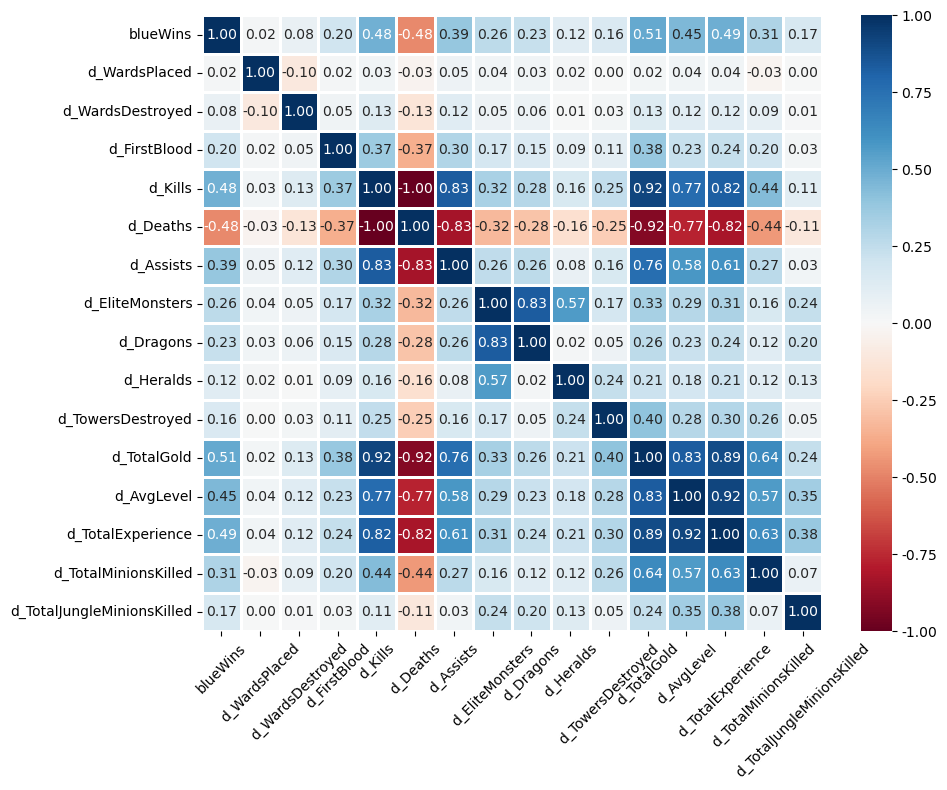

In [158]:
plt.subplots(figsize=(10, 8))
plt.rcParams['axes.unicode_minus'] = False
plt.tick_params(labelsize=10)                                                                       # XY轴字体大小
sns.heatmap(df.corr(), cmap='RdBu', annot=True, fmt='0.2f',linewidths=2,annot_kws={'size':10})
plt.xticks(rotation=45)
plt.show()

##### 4.3.3.2 特征重要性

In [159]:

centroid = {}
for col in df.columns:
    if col =='blueWins':
        continue
    positive =  df[df['blueWins'] == 1][col].mean()
    negative =  df[df['blueWins'] == 0][col].mean()
    discrimination = np.abs(positive-negative) / (np.max([np.abs(positive), np.abs(negative)]) + np.finfo(float).tiny)          # 为每列构造偏离度
    centroid[col] = discrimination


sorted_centroid= dict(sorted(centroid.items(), key=lambda item: item[1], reverse=True))                                         # 按值大小降序排列字典

for key, value in sorted_centroid.items():
    print(f'{key}: {value:.7}')
    

d_Assists: 1.988626
d_TotalGold: 1.973518
d_Kills: 1.951362
d_Deaths: 1.951362
d_TotalExperience: 1.934536
d_AvgLevel: 1.921129
d_FirstBlood: 1.905514
d_TotalMinionsKilled: 1.876174
d_EliteMonsters: 1.849155
d_TowersDestroyed: 1.713006
d_WardsPlaced: 1.695247
d_Dragons: 1.604684
d_TotalJungleMinionsKilled: 1.502748
d_Heralds: 1.437339
d_WardsDestroyed: 1.355225


In [160]:
df = df.drop(columns=['d_Heralds','d_WardsDestroyed'])

##### 4.3.3.3 特征的PDF

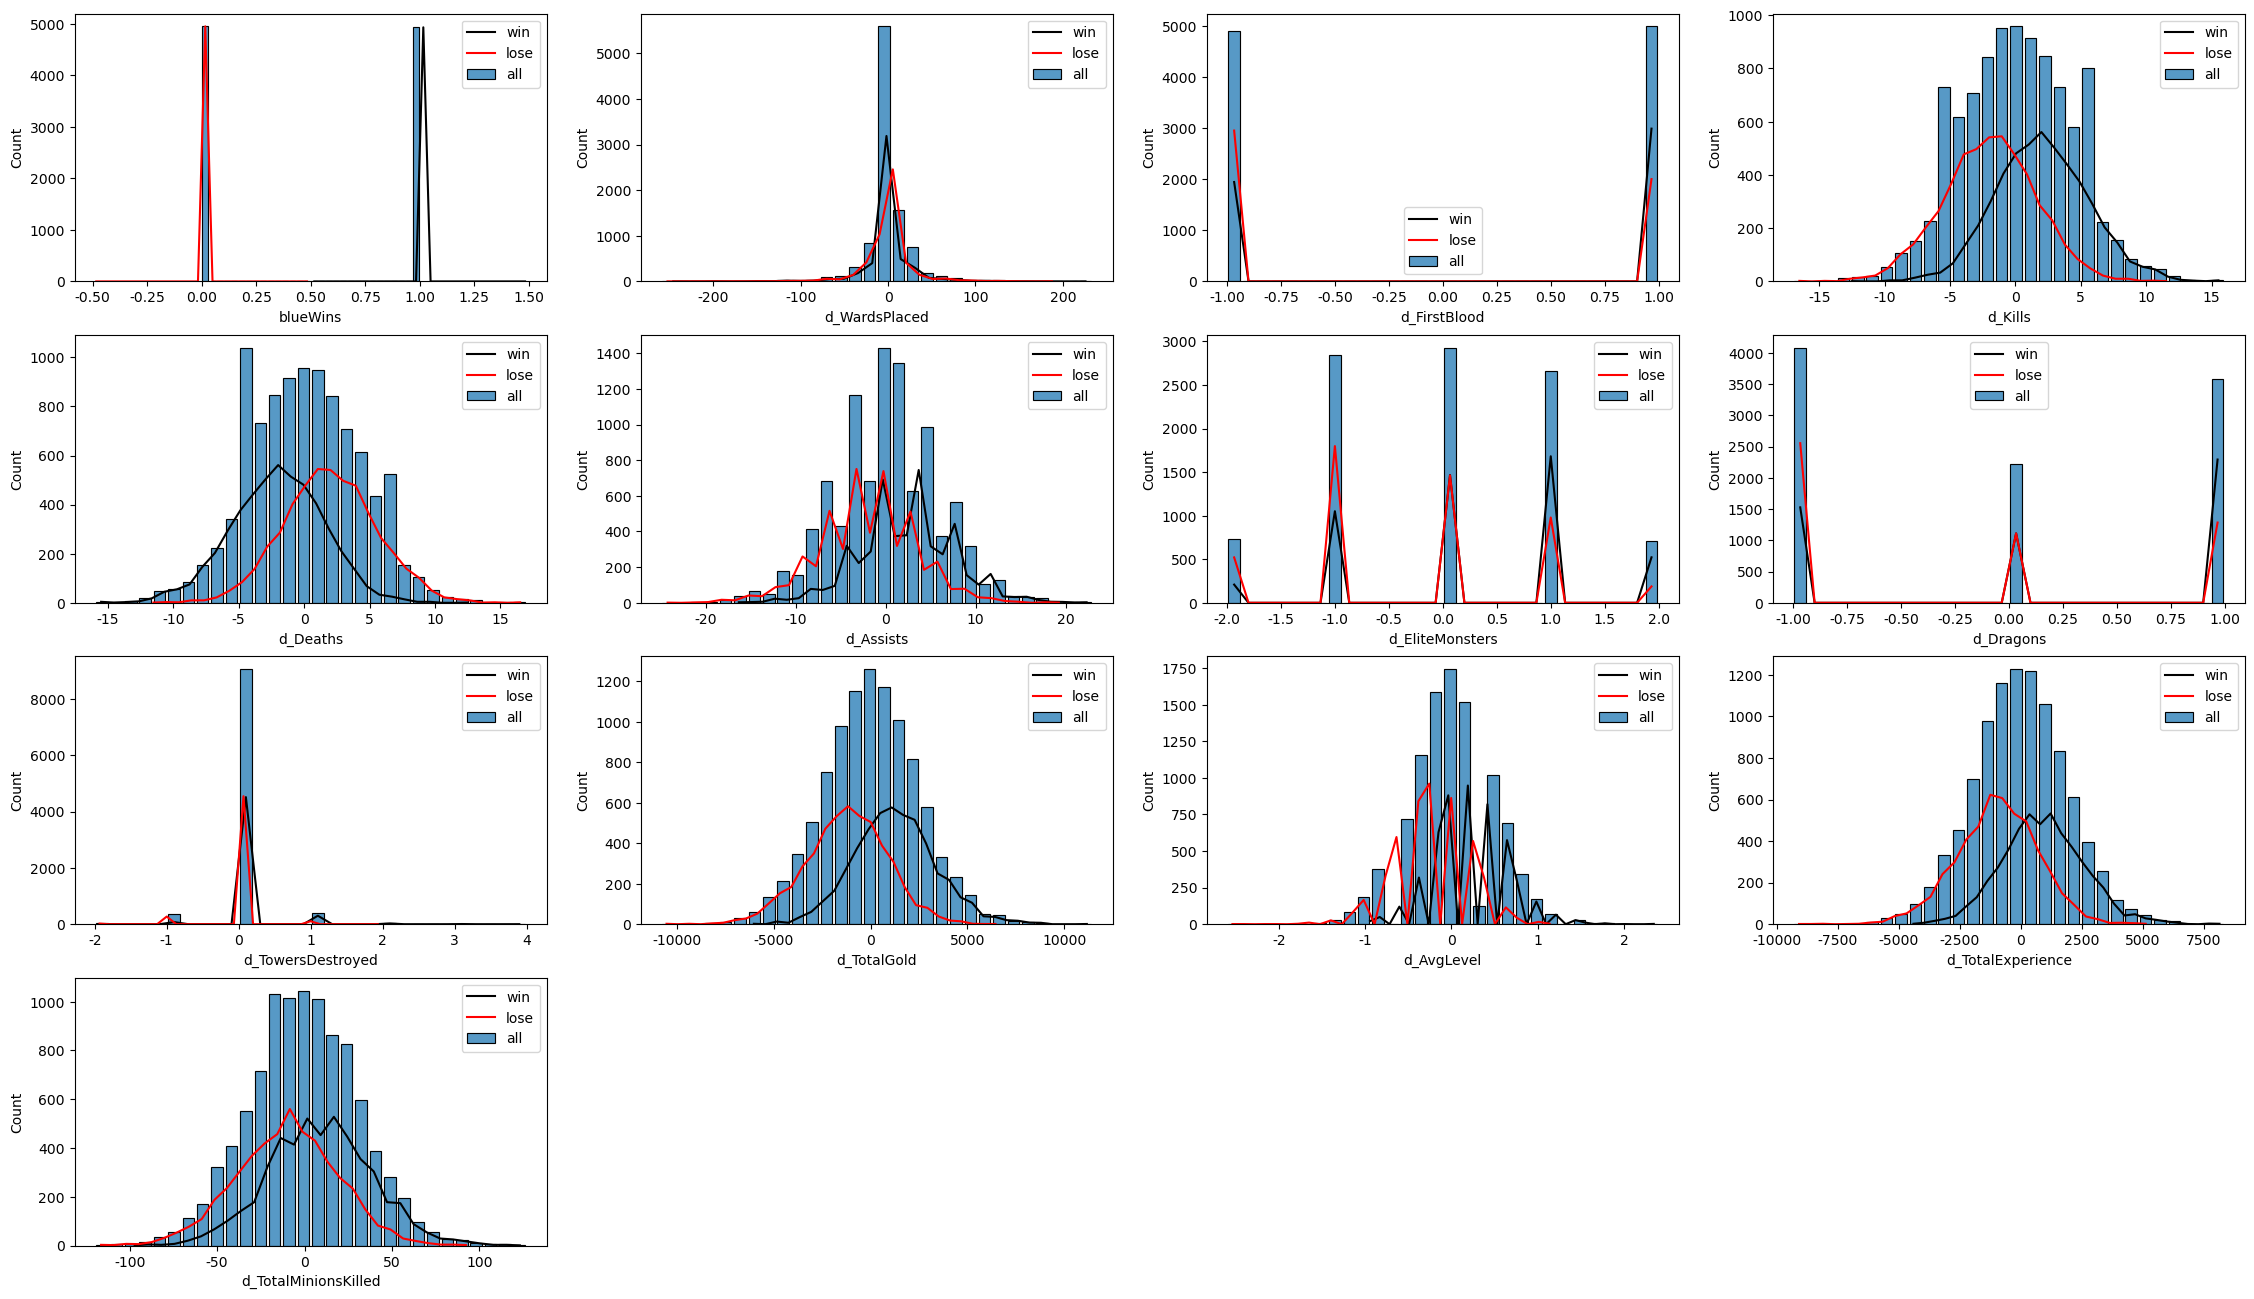

In [161]:
# 分离正负例
positive_samples = df[df['blueWins'] == 1]
negative_samples = df[df['blueWins'] == 0]

# 计算行数和列数
num_features = len(df.columns) - 1                                                                                              # 排除标签列
num_cols = 4                                                                                                                    # 每行显示的子图数量
num_rows = -(-num_features // num_cols)                                                                                         # 向上取整

# 设置子图的布局
plt.figure(figsize=(7 * num_cols, 4 * num_rows))

# 对每个特征分别画出正负例的PDF图
for i, col in enumerate(df.columns[:-1]):                                                                                       # 排除最后一列（标签列）
    ax =plt.subplot(num_rows, num_cols, i + 1)                                                                                  # 按照计算得到的行数和列数设置子图位置
    
    # 画图
    sns.histplot(df[col], bins=30, ax=ax, shrink=.8, label='all')
    # 绘制正例的曲线图
    sns.histplot(positive_samples[col],bins=30, ax=ax,  shrink=.8, element = 'poly', color='black',  fill=False, label='win')
    # 绘制负例的曲线图
    sns.histplot(negative_samples[col],bins=30, ax=ax,  shrink=.8, element = 'poly', color='red',  fill=False, label='lose')

    # 添加图标和标签
    #plt.title(f'{col}', x=0.5, y=-0.175, fontweight='bold')
    #plt.xlabel('Feature Values')
    #plt.ylabel('Probability Density')
    plt.legend()
    #plt.grid(True)

# 调整子图之间的间距
#plt.tight_layout()
# 显示图形
plt.show()


##### 4.3.3.4 特征的CDF

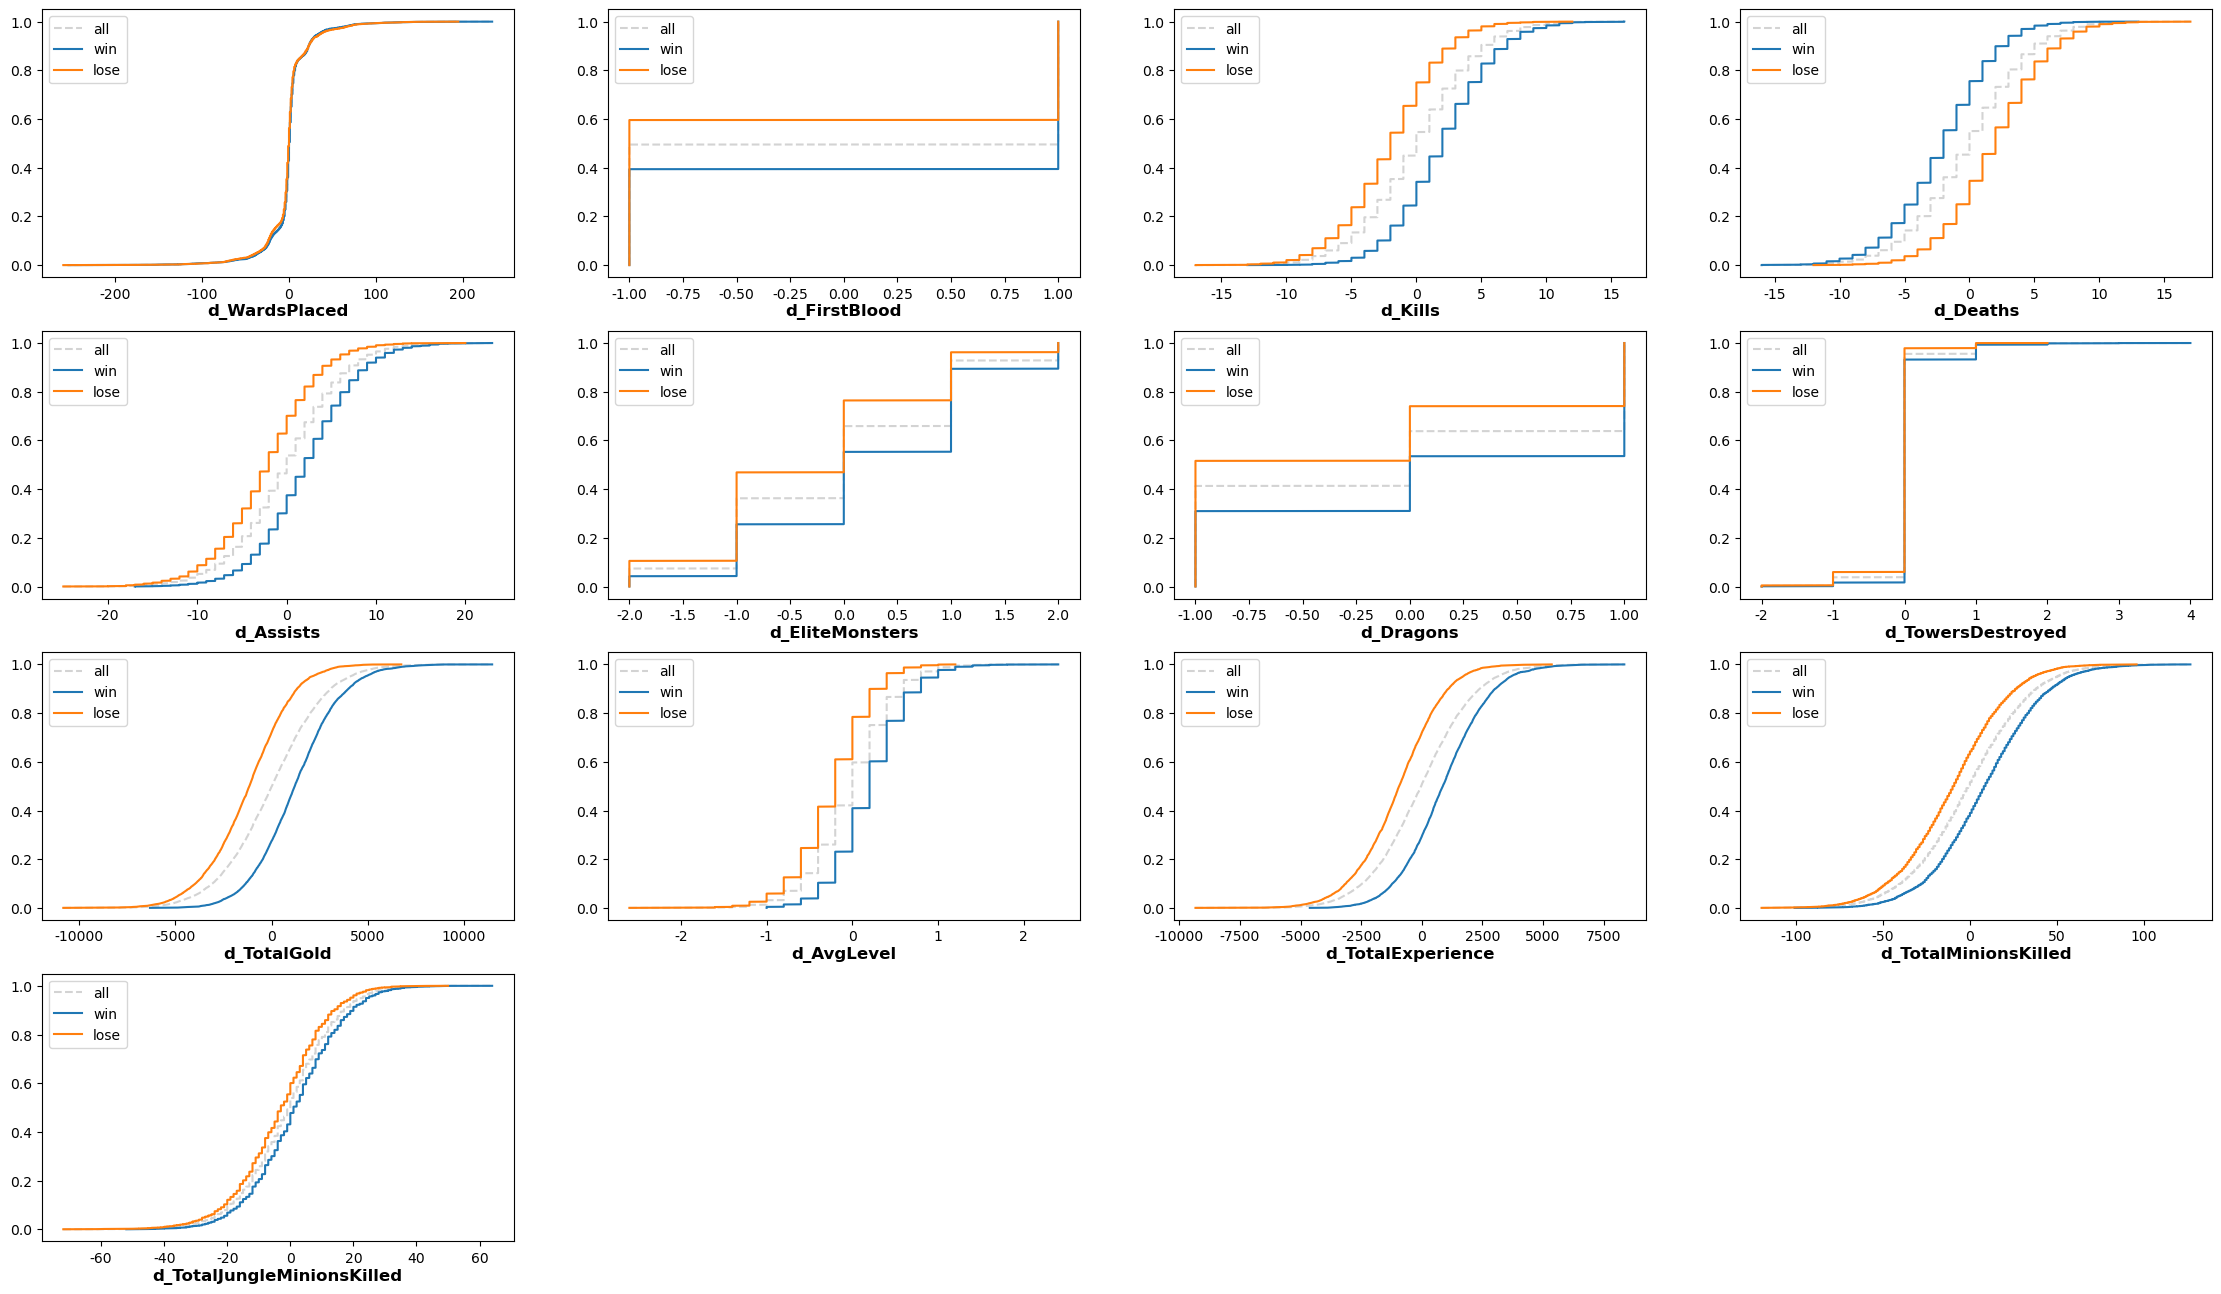

In [162]:
# 分离正负例
positive_samples = df[df['blueWins'] == 1]
negative_samples = df[df['blueWins'] == 0]

# 计算行数和列数
num_features = len(df.columns) - 1  # 排除标签列
num_cols = 4  # 每行显示的子图数量
num_rows = -(-num_features // num_cols)  # 向上取整

# 设置子图的布局
plt.figure(figsize=(7 * num_cols , 4 * num_rows))
plt.rcParams['axes.unicode_minus'] = False

# 对每个特征分别画出正负例的CDF图
for index, col in enumerate(df.columns[1:]):  # 排除第一列（标签列）
    plt.subplot(num_rows, num_cols, index + 1)  # 按照计算得到的行数和列数设置子图位置
    ecdf_all = ECDF(df[col])
    ecdf_positive = ECDF(positive_samples[col])
    ecdf_negative = ECDF(negative_samples[col])

    # 画图
    plt.plot(ecdf_all.x, ecdf_all.y, color='lightgrey', label='all', linestyle='--', )
    plt.plot(ecdf_positive.x, ecdf_positive.y, label='win')
    plt.plot(ecdf_negative.x, ecdf_negative.y, label='lose')

    # 添加图标和标签
    plt.title(f'{col}', x=0.5, y=-0.175, fontweight='bold')
    #plt.xlabel('Feature Values')
    #plt.ylabel('Cumulative Probability')
    plt.legend()
    #plt.grid(True)

# 调整子图之间的间距
#plt.tight_layout()

# 显示图形
plt.show()

##### 4.3.3.5 单一数值特征分析

                   d_Kills iou: 0.420945  overlap: 0.592548
                  d_Deaths iou: 0.420945  overlap: 0.592548
               d_TotalGold iou: 0.204665  overlap: 0.362167
         d_TotalExperience iou: 0.252027  overlap: 0.406422
      d_TotalMinionsKilled iou: 0.594729  overlap: 0.745869


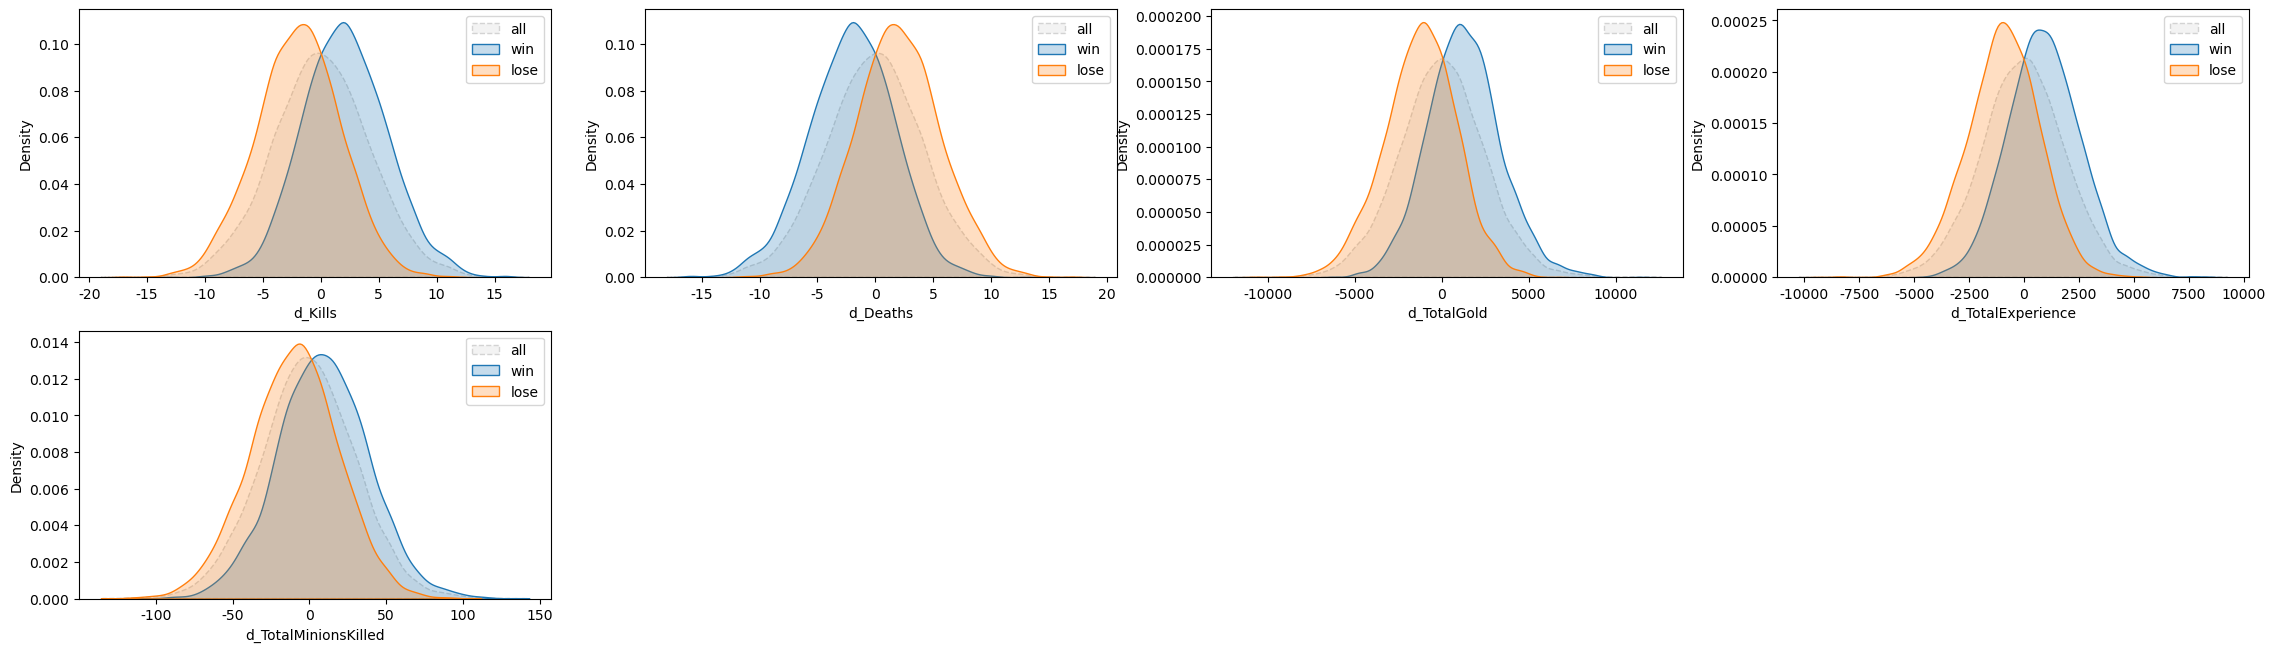

In [163]:


# 分离正负例
positive_samples = df[df['blueWins'] == 1]
negative_samples = df[df['blueWins'] == 0]

# 计算行数和列数
num_features = len(df.columns) - 1  # 排除标签列
num_cols = 4  # 每行显示的子图数量
num_rows = -(-num_features // num_cols)  # 向上取整

# 设置子图的布局
plt.figure(figsize=(7 * num_cols , 4 * num_rows))
plt.rcParams['axes.unicode_minus'] = False

# 对每个特征分别画出正负例的KDE图
for index, col in enumerate(df[['d_Kills', 'd_Deaths', 'd_TotalGold', 'd_TotalExperience', 'd_TotalMinionsKilled']].columns):  # 只选近拟正态分布的数值特征
    plt.subplot(num_rows, num_cols, index + 1)  # 按照计算得到的行数和列数设置子图位置

    # 画KDE图
    sns.kdeplot(df[col], label='all', linestyle='--', color='lightgrey', fill=True)                                            # cumulative
    sns.kdeplot(positive_samples[col], label='win', fill=True)
    sns.kdeplot(negative_samples[col], label='lose', fill=True)

    # 添加图标和标签
    #plt.title(f'{col}', x=0.5, y=-0.175, fontweight='bold')
    # plt.xlabel('Feature Values')
    # plt.ylabel('Probability Density')
    plt.legend()

    # 使用KernelDensity估计正负例的概率密度函数
    kde_positive = KernelDensity(bandwidth=0.5, kernel='gaussian')
    kde_positive.fit(positive_samples[col].values.reshape(-1, 1))

    kde_negative = KernelDensity(bandwidth=0.5, kernel='gaussian')
    kde_negative.fit(negative_samples[col].values.reshape(-1, 1))

    # 生成一组用于计算交集和并集的值
    x_values = np.linspace(min(df[col]), max(df[col]), 1000).reshape(-1, 1)

    # 计算正负例的KDE值
    kde_values_positive = np.exp(kde_positive.score_samples(x_values))
    kde_values_negative = np.exp(kde_negative.score_samples(x_values))

    # 计算交集和并集
    intersection = np.minimum(kde_values_positive, kde_values_negative)
    union = np.maximum(kde_values_positive, kde_values_negative)

    # 计算交并集的面积（）
    intersection_area = np.trapz(intersection, x=x_values.flatten())
    union_area = np.trapz(union, x=x_values.flatten())
    positive_area = np.trapz(kde_values_positive, x=x_values.flatten())
    negative_area = np.trapz(kde_values_negative, x=x_values.flatten())
    # 重叠比
    iou = intersection_area / union_area
    overlap = intersection_area / min(positive_area, negative_area )
    col = col.rjust(26, ' ')

    # 打印结果
    #print(f'{col} intersection_area: {intersection_area:.6f}  positive_area: {positive_area:.6f}  negative_area: {negative_area:.6f}')
    print(f'{col} iou: {iou:.6f}  overlap: {overlap:.6f}')


# 调整子图之间的间距
# plt.tight_layout()

# 显示图形
plt.show()


##### 4.3.3.6 特征的散点分布

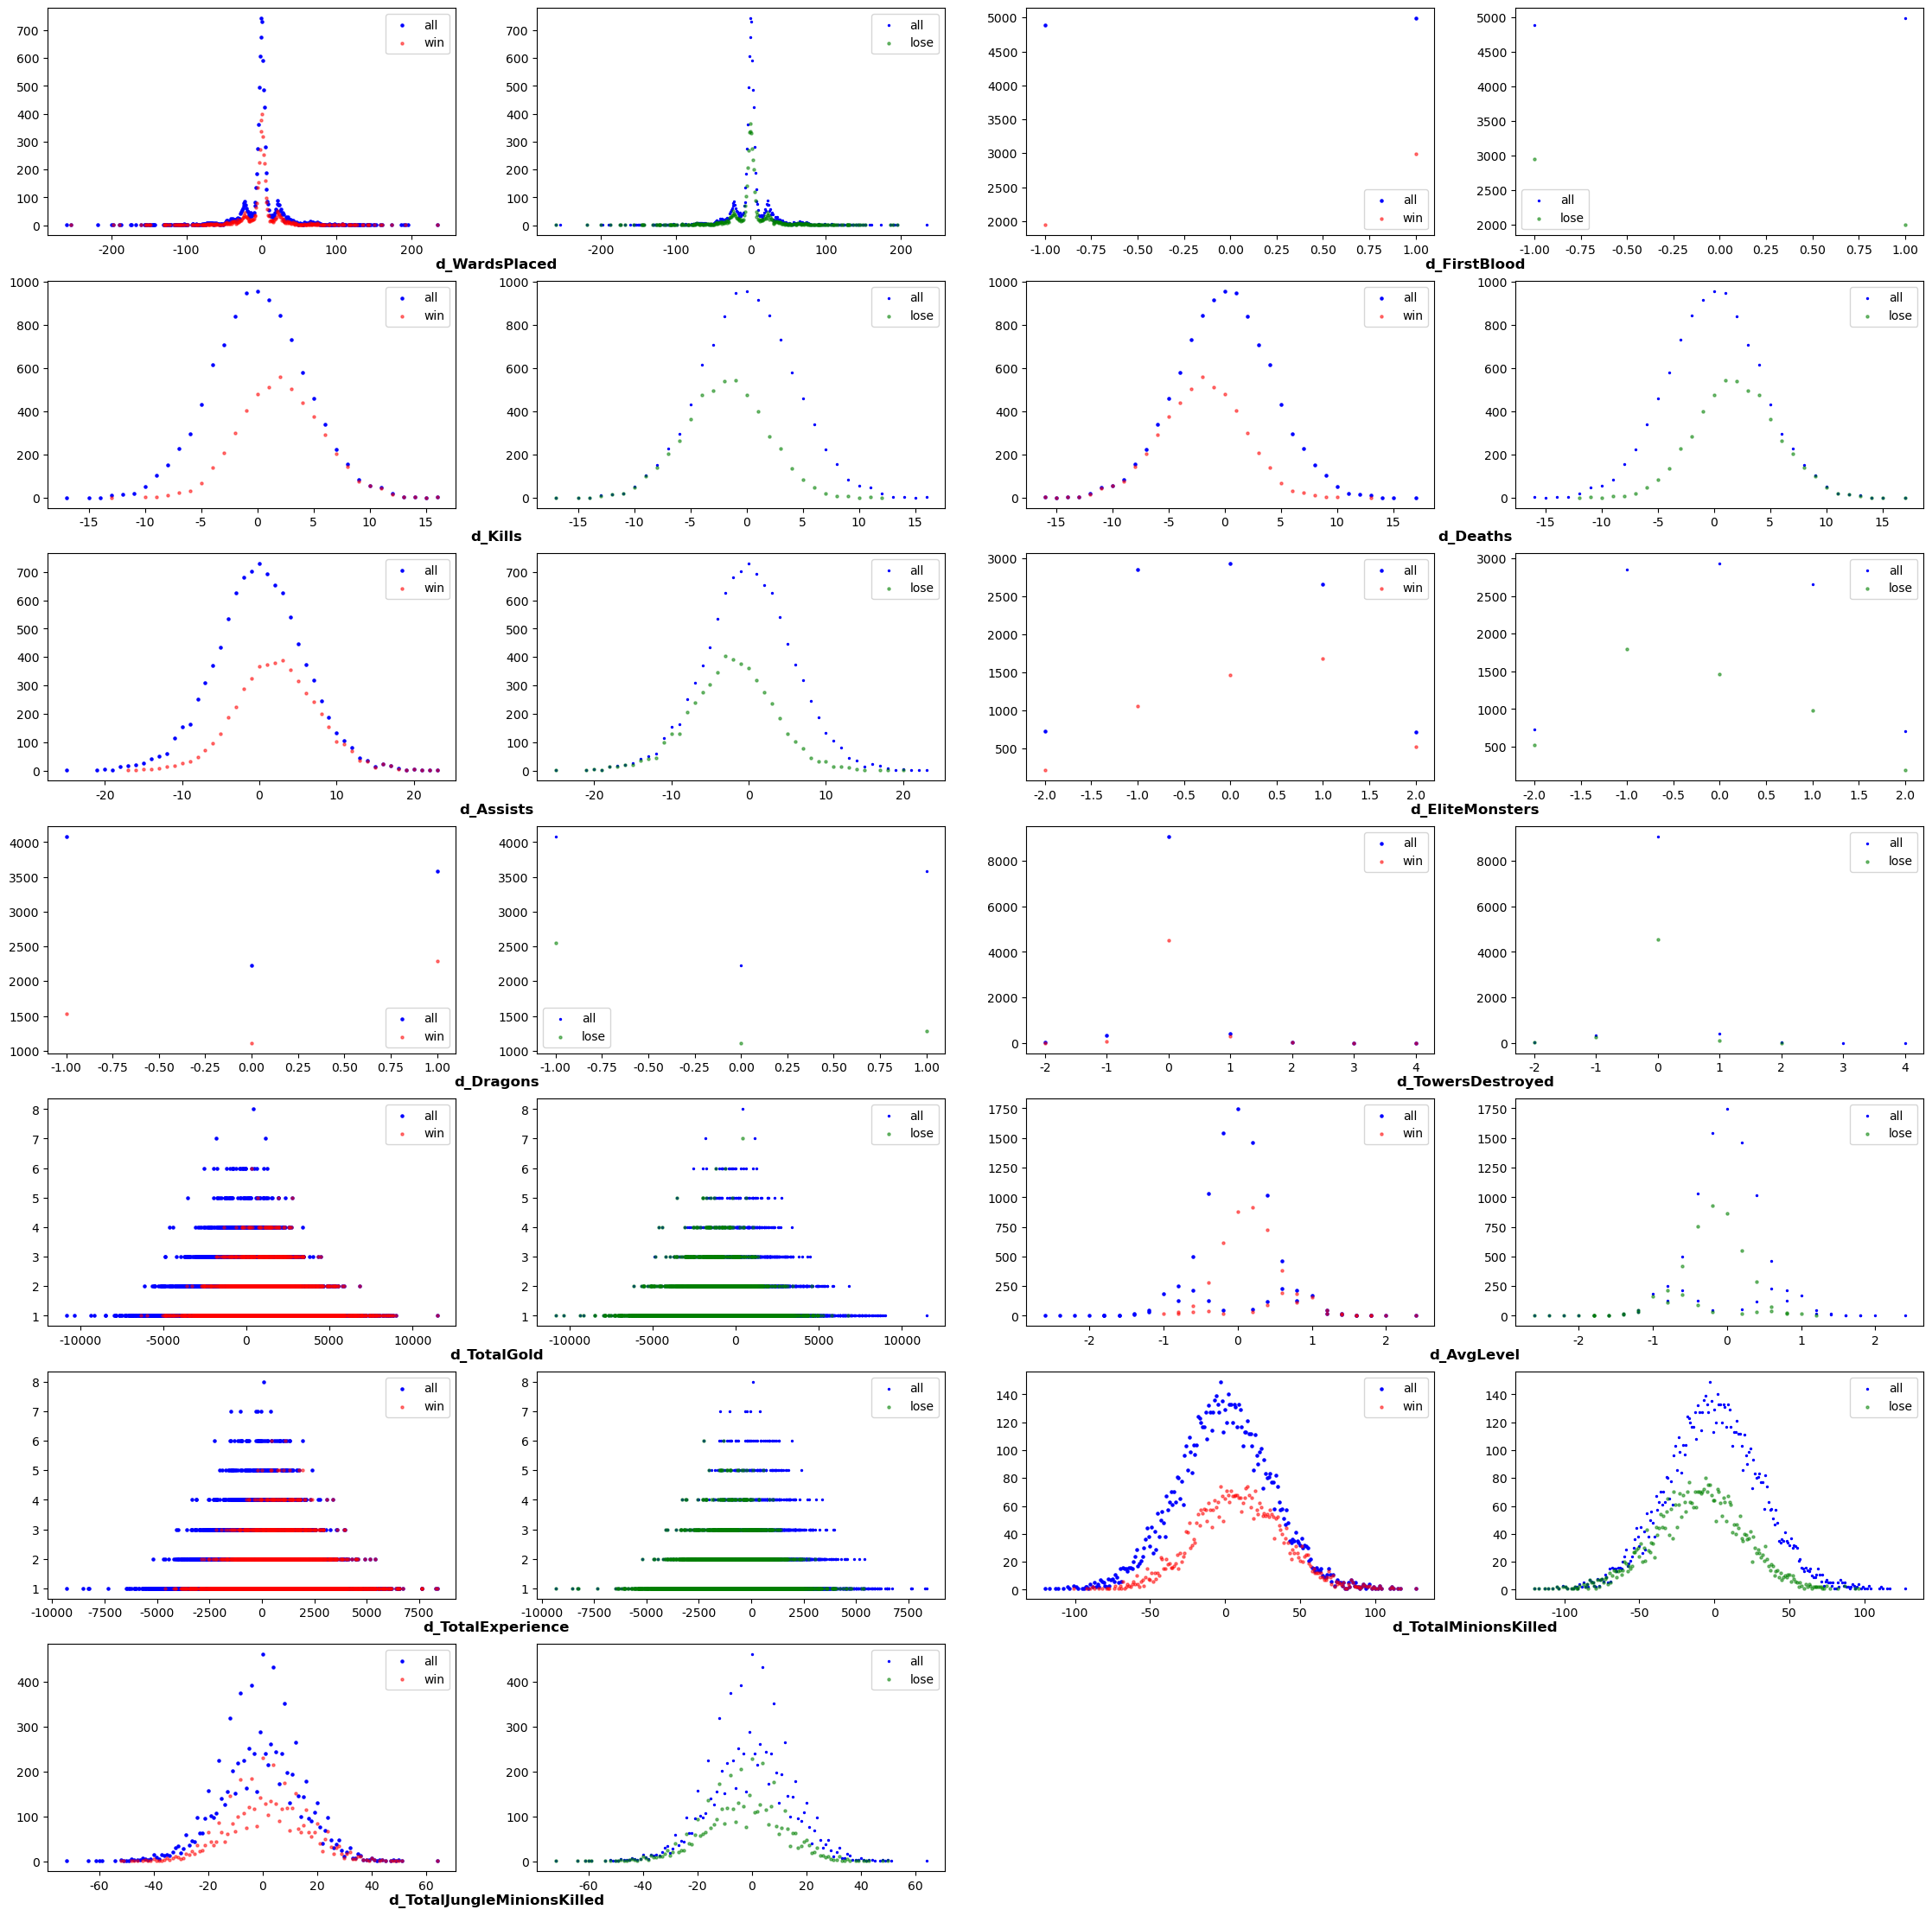

In [164]:
# 分离正负例
positive_samples = df[df['blueWins'] == 1]
negative_samples = df[df['blueWins'] == 0]

# 计算行数和列数
num_features = len(df.columns) - 1  # 排除标签列
num_cols = 2  # 每行显示的特征数量
num_rows = -(-num_features // num_cols)  # 向上取整

# 设置子图的布局
plt.figure(figsize=(14 * num_cols , 4 * num_rows))
plt.rcParams['axes.unicode_minus'] = False

# 对每个特征分别画出正负例的CDF图
for index, col in enumerate(df.columns[1:]):  # 排除第一列（标签列）
    a = Counter(df[col])
    t = Counter(positive_samples[col])
    f = Counter(negative_samples[col])
    
    # 画图
    plt.subplot(num_rows, num_cols * 2, index*2 +1)  # 按照计算得到的行数和列数设置子图位置
    plt.scatter(a.keys(), a.values(), s=5, c='b', label='all')
    plt.scatter(t.keys(), t.values(), alpha=0.5, s=5, c='r', label='win')
    plt.legend()


    plt.subplot(num_rows, num_cols * 2, index * 2 + 2)  # 按照计算得到的行数和列数设置子图位置
    plt.scatter(a.keys(), a.values(), s=2, c='b', label='all')
    plt.scatter(f.keys(), f.values(), alpha=0.5, s=5, c='g',label='lose')
    plt.legend()

    # 添加图标和标签
    plt.title(f'{col}', x=-0.1, y=-0.175, fontweight='bold')

# 调整子图之间的间距
#plt.tight_layout()

# 显示图形
plt.show()

##### 4.3.3.7 数据箱线图

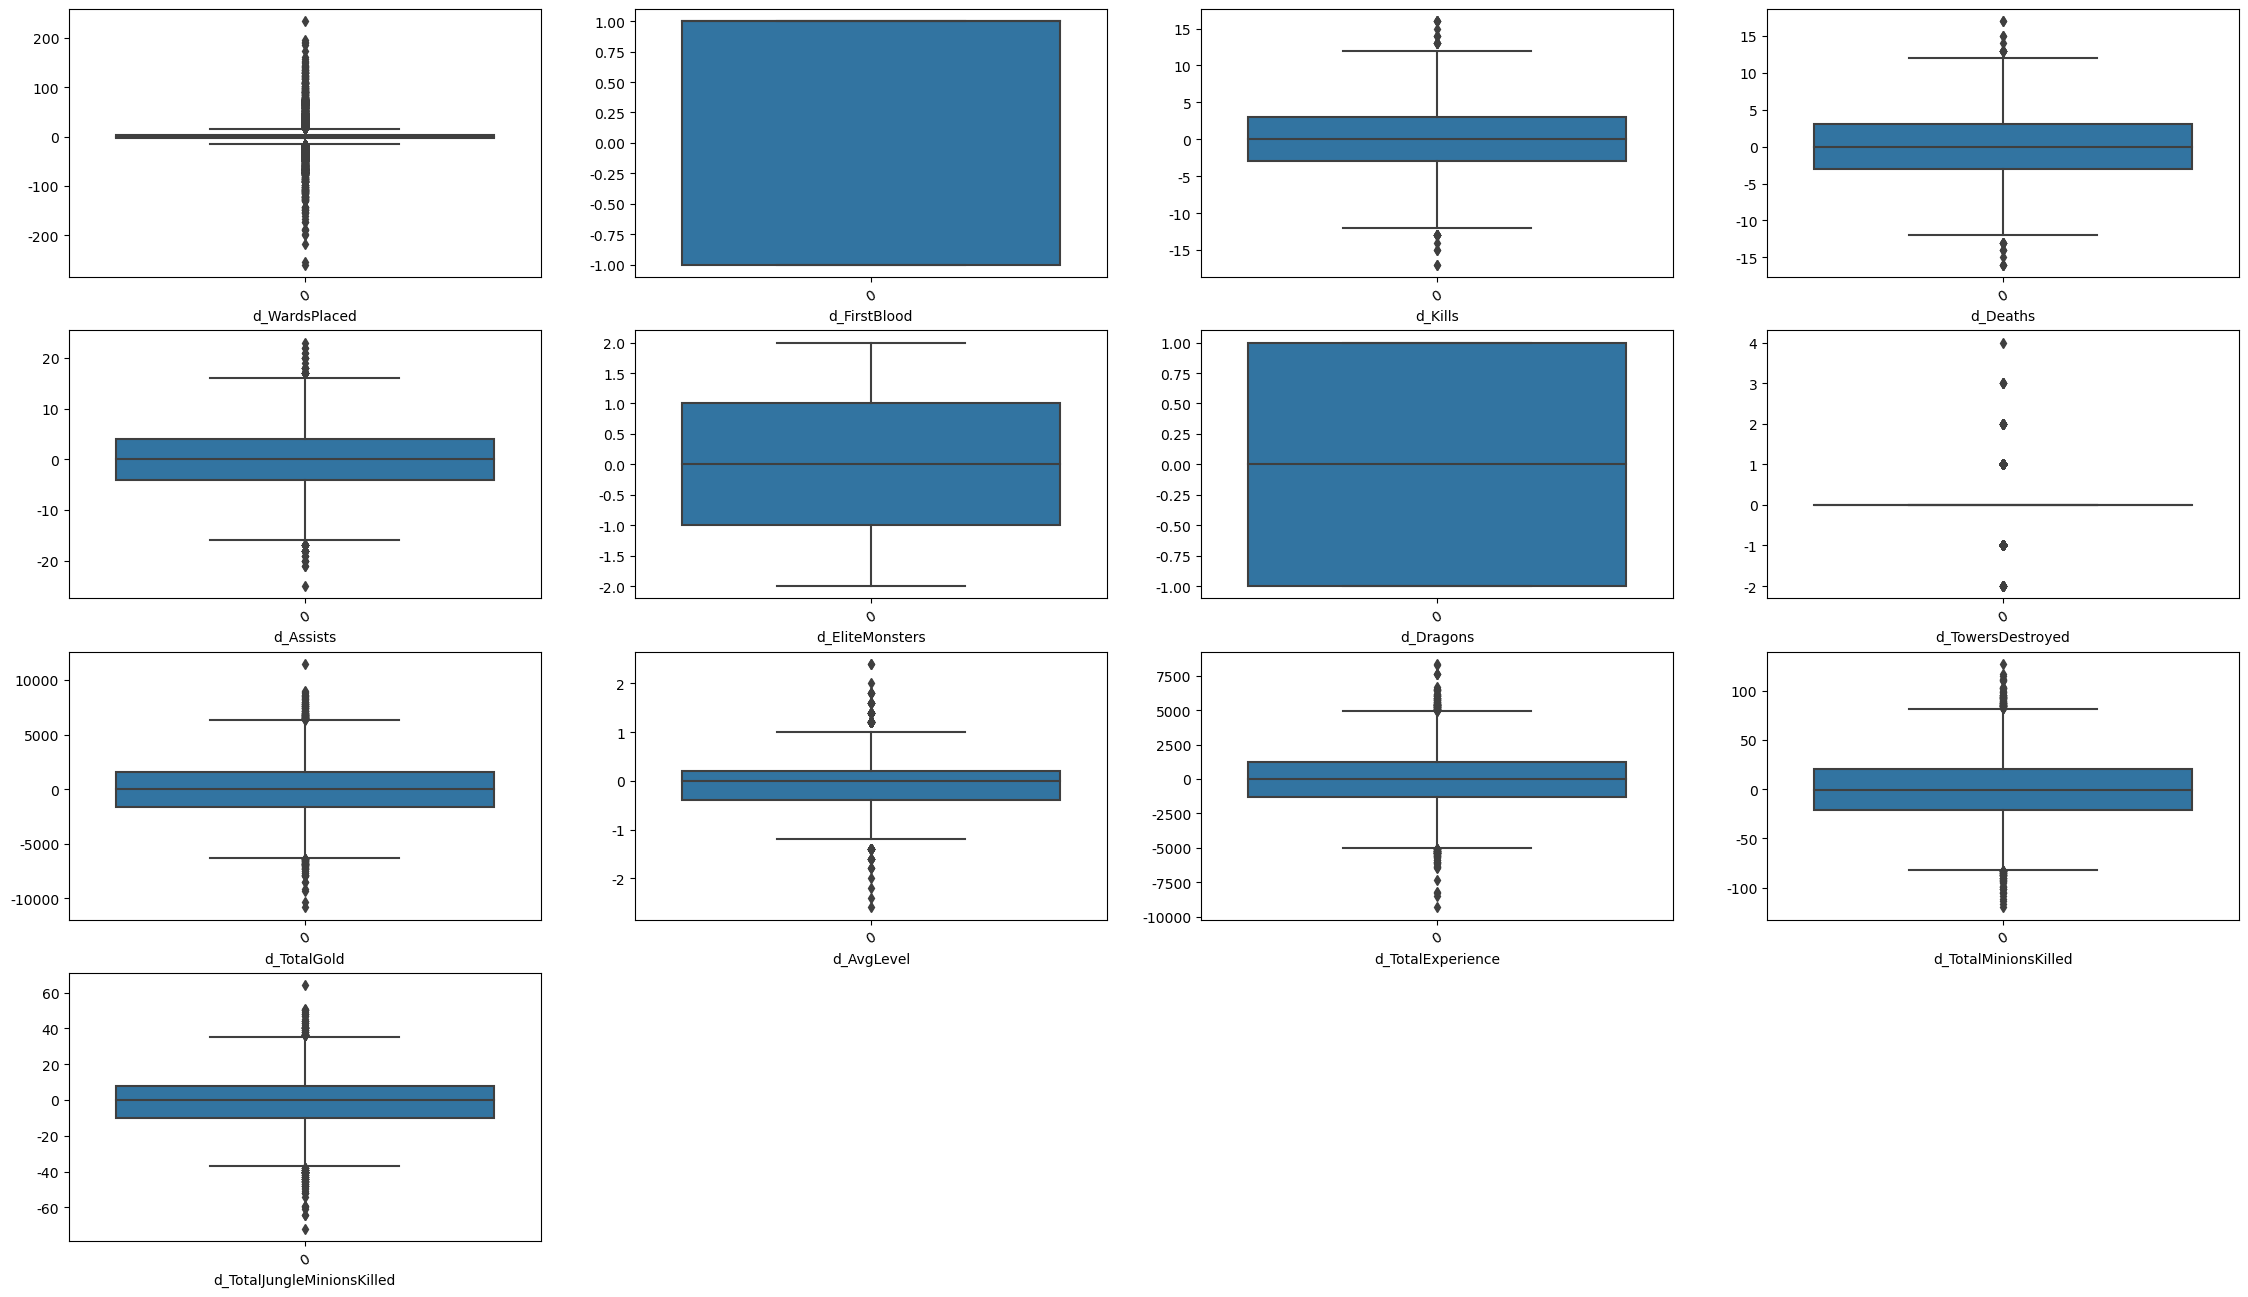

In [165]:
# 计算行数和列数
num_features = len(df.columns) - 1  # 排除标签列
num_cols = 4  # 每行显示的子图数量
num_rows = -(-num_features // num_cols)  # 向上取整

# 设置子图的布局
plt.figure(figsize=(7 * num_cols , 4 * num_rows))
plt.rcParams['axes.unicode_minus'] = False

# 对每个特征分别画出正负例的CDF图
for index, col in enumerate(df.columns[1:]):  # 排除第一列（标签列）
    plt.subplot(num_rows, num_cols, index + 1)  # 按照计算得到的行数和列数设置子图位置

    plt.rcParams['axes.unicode_minus'] = False
    plt.xticks(rotation=30)      
    sns.boxplot(data=df[col].values)   
    plt.xlabel(col)

    # 添加图标和标签alpha=0.5, 
    #plt.title(f'{col}', x=0.5, y=-0.175, fontweight='bold')
    #plt.xlabel('Feature Values')
    #plt.ylabel('Cumulative Probability')
    #plt.legend()
    #plt.grid(True)

# 调整子图之间的间距
#plt.tight_layout()

# 显示图形
plt.show()

In [166]:
# 箱型图处理异常点
def box_outlier(data):
    df_box = data.copy()
    for col in df_box.columns:                                              # 对每一列分别用箱型图进行判断
        if col == 'blueWins': 
            continue
        Q1 = df_box[col].quantile(q=0.25)                                   # 下四分位
        Q3 = df_box[col].quantile(q=0.75)                                   # 上四分位
        low_whisker = Q1 - 3 * (Q3 - Q1)                                    # 下边缘
        up_whisker = Q3 + 3 * (Q3 - Q1)                                     # 上边缘
        
        # 寻找异常点,用上下边缘重置
        rule_low =(df_box[col] < low_whisker)  
        rule_up = (df_box[col] > up_whisker) 
        df_box.loc[rule_low, col] = low_whisker
        df_box.loc[rule_up, col] = up_whisker
    return df_box

df_box = box_outlier(df)
df_box 

,blueWins,d_WardsPlaced,d_FirstBlood,d_Kills,d_Deaths,d_Assists,d_EliteMonsters,d_Dragons,d_TowersDestroyed,d_TotalGold,d_AvgLevel,d_TotalExperience,d_TotalMinionsKilled,d_TotalJungleMinionsKilled
0,0,13,1,3,-3,3,0,0,0,643.0,-0.2,-8.0,-2,-19
1,0,0,-1,0,0,3,-2,-1,0,-2908.0,-0.2,-1173.0,-66,-9
2,0,0,-1,-4,4,-10,1,1,0,-1172.0,-0.4,-1033.0,-17,18
3,0,28,-1,-1,1,-5,1,0,0,-1321.0,0.0,-7.0,-34,8
4,0,28,-1,0,0,-1,-1,-1,0,-1004.0,0.0,230.0,-15,-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9874,1,-28,1,3,-3,-2,1,1,0,2519.0,0.4,2469.0,-18,35
9875,1,28,-1,2,-2,5,1,1,0,782.0,0.2,888.0,27,-8
9876,0,9,-1,-1,1,-6,-1,-1,0,-2416.0,-0.4,-1877.0,-51,-15
9877,0,-28,1,-1,1,2,1,1,0,-839.0,-0.6,-1085.0,-23,8


#### 4.3.4 特征离散化

通过上面三和四步骤的观察，我们把特征分为三个大类：
1. 连续的数值比较少的，保持不变；
2. 连续的数值适中的，分为一类离散化；
3. 连续的数值比较大的，分为一类离散化。

In [167]:
for c in df_box.columns[1:]: # 遍历每一列特征，跳过标签列
    if 'FirstBlood' in c or 'EliteMonsters' in c or 'Dragons' in c or 'Heralds' in c or 'TowersDestroyed' in c:
        continue 
    elif  'TotalGold' in c  or 'TotalExperience ' in c  :    #'WardsPlaced' in c or 'Assists' in c  or 'TowersDestroyed'  in c  or 'TotalGold' in c  or 'TotalExperience ' in c  :     

        #df_box[c] = pd.qcut(df_box[c].rank(method='first'), 5, labels=[1,2,3,4,5])
        df_box[c] = pd.qcut(df_box[c].rank(method='first'), 7, labels=[1,2,3,4,5,6,7])
    else:
        df_box[c] = pd.qcut(df_box[c].rank(method='first'), 2, labels=[1,2])  
        #discrete_df[c] = pd.qcut(df[c].rank(method='first'), 3, labels=[1,2,3])  
        #discrete_df[c] = pd.qcut(df[c].rank(method='first'), 4, labels=[1,2,3,4])  
        #discrete_df[c] = pd.qcut(df[c].rank(method='first'), 5, labels=[1,2,3,4,5])   
df_box

,blueWins,d_WardsPlaced,d_FirstBlood,d_Kills,d_Deaths,d_Assists,d_EliteMonsters,d_Dragons,d_TowersDestroyed,d_TotalGold,d_AvgLevel,d_TotalExperience,d_TotalMinionsKilled,d_TotalJungleMinionsKilled
0,0,2,1,2,1,2,0,0,0,5,1,2,1,1
1,0,1,-1,1,1,2,-2,-1,0,1,1,1,1,1
2,0,1,-1,1,2,1,1,1,0,3,1,1,1,2
3,0,2,-1,1,2,1,1,0,0,2,1,2,1,2
4,0,2,-1,1,1,1,-1,-1,0,3,1,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9874,1,1,1,2,1,1,1,1,0,6,2,2,1,2
9875,1,2,-1,2,1,2,1,1,0,5,2,2,2,1
9876,0,2,-1,1,2,1,-1,-1,0,2,1,1,1,1
9877,0,1,1,1,2,2,1,1,0,3,1,1,1,2


### 4.4 数据集准备

In [168]:
all_y = df_box['blueWins'].values                                                                           # 所有标签数据
feature_names = df_box.columns[1:]   # 所有特征的名称
all_x = df_box[feature_names].values                                                                   # 所有原始特征值，DataFrame.values取出为numpy的array矩阵


x_train, x_test, y_train, y_test = train_test_split(all_x, all_y, test_size=0.2, random_state=RANDOM_SEED)  # 划分训练集和测试集
x_train, x_validation , y_train, y_validation  = train_test_split(x_train, y_train, test_size=0.2, random_state=RANDOM_SEED)
all_y.shape, all_x.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape                          # 输出数据行列信息

((9879,), (9879, 13), (6322, 13), (1976, 13), (6322,), (1976,))

###  4.5决策树模型的实现

In [169]:
# 定义决策树类
class DecisionTree(object):
    def __init__(self, classes, features, 
                 max_depth=10, min_samples_split=10,
                 impurity_t='entropy'):
        '''
        classes表示模型分类总共有几类
        features是每个特征的名字，也方便查询总的共特征数
        max_depth表示构建决策树时的最大深度
        min_samples_split表示构建决策树分裂节点时，如果到达该节点的样本数小于该值则不再分裂
        impurity_t表示计算混杂度（不纯度）的计算方式，例如entropy或gini
        '''  
        self.classes = classes
        self.features = features
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.impurity_t = impurity_t
        self.root = None # 定义根节点，未训练时为空
        
    # 按输出类别统计占比（P）。Counter也可以，但这个更简单。
    def label_score(self, label):
        '''按输出类别统计占比（P）'''
        label_count = len(label)                                                             #label 的总样本数
        if isinstance(label,list):
            return [ label.count(x) /label_count for x in np.unique(label)]
        else:   
            labels =label.tolist()
            return [ labels.count(x) /label_count for x in np.unique(labels)]
        
    #混杂度计算，支持三种方式：熵；Gini；错分类。
    def impurity(self, label):
        '''混杂度计算，支持三种方式：熵；Gini；错分类。'''
        precision_j =self.label_score(label)                                            #取label属性占比
        if self.impurity_t == 'entropy':                                                #熵
            return -np.sum(np.multiply(precision_j, np.log2(precision_j)))
        elif self.impurity_t == 'gini':                                                 #基尼
            return 1-np.sum(np.power(precision_j, 2))
        elif self.impurity_t == 'mis-classification':                                   #错分类
            return 1-np.max(precision_j)
        else:
            return 1

    #调用impurity用来计算信息增益
    def gain(self, feature, label):
        '''按信息增益最大，找出最佳属性节点。注意返回的是最佳节点的索引。'''
        impurity_original = self.impurity(label)                                        #原始熵值
        ig_best = 0                                                                     #信息增益
        feature_best_index = -1                                                         #信息增益值最好的特征索引
        for x in range(len(feature[0])):                                                #遍历每个特征，x为特征索引
            impurity_sons = 0
            for z in set([y[x] for y in feature]):                                      #遍历特征对应的属性，z为属性值
                label_z=[label[i] for i in range(len(feature)) if feature[i][x] == z]   #遍历训练集记录，找出该属性值对应label
                impurity_z = self.impurity(label_z)                                     #属性下对应的节点的熵值
                impurity_sons +=impurity_z* len(label_z) / len(feature)                 #累加期望熵值
            ig_new = (impurity_original - impurity_sons)                                #新特征的信息增益
            if ig_new > ig_best:
                ig_best = ig_new
                feature_best_index = x            
        if ig_best ==0 and  len(feature[0]) >=2 :                           #特殊情景处理：当前子集中所有属性（两个以以上）分裂的信息增益为0，那么默认取第一个。       
                feature_best_index = 0
        return feature_best_index

    #训练时递归函数分裂节点
    def expand_node(self, feature, label,depth): 
        if len(feature) <= self.min_samples_split:                          #如果该节点的样本数小于预设值，停止分裂，并置叶子节点为标签中最常见的值   
            return  Counter(label).most_common(1)[0][0]
        if depth > self.max_depth:                                          #如果深度大于预设值，停止分裂，并置叶子节点为标签中最常见的值
            return  Counter(label).most_common(1)[0][0]
        if len(np.unique(label)) == 1:                                      #如果有完全相同的输出类别，停止分裂。
            return label[0]

        divide_break = True                                                 #如果有完全相同的输入特征，停止分裂。并置叶子节点为标签中最常见的值
        for s in range(len(feature)):
            if not divide_break:
                break;
            feature_s = feature[s]
            for t in range(1,len(feature_s)):
                if feature_s[t] != feature_s[0]:
                    divide_break = False
                    break;
        if divide_break:
            return  Counter(label).most_common(1)[0][0]

        node_best = self.gain(feature, label)                               #按信息增益最大，找出当前子集中最佳属性节点
        node_best_values =set( [x[node_best] for x in feature])             #取出最佳属性节点的去重元素集
        node_need = {node_best:{}}
        for x in node_best_values:                                          #递归构造当前最佳属性节点对应的子结点树(子集中去除当前的特征信息)       
            #feature_label_son = [[np.delete(feature[y],node_best),label[y]] for y in range(len(feature)) if feature[y][node_best] ==x]
            #feature_label_sons = np.matrix(feature_label_son)
            #node_need[node_best][x] = self.expand_node(feature_label_sons[:,0].tolist(), feature_label_sons[:,1].tolist(), depth+1)
            #可读性欠佳，改写：
            feature_son = []
            label_son = []
            for y in reversed(range(len(feature))):
               feature_y = feature[y]
               if feature_y[node_best] ==x :
                   feature_son.append(np.delete(feature_y,node_best))
                   label_son.append(label[y])
            node_need[node_best][x] = self.expand_node(feature_son, label_son, depth+1)
        return node_need

    #预测时遍历节点
    def traverse_node(self,node,feature):
        node_key = [x for x in node.keys()][0]                              #决策结点的索引
        node_val = node[node_key]                                           #决策结点的值（包含特征值和子决策点树）
        feature_val = feature[node_key]                                     #样本对应该决策结点的特征值
        sub_node_keys = [x for x in node_val.keys()]                        #决策结点的子结点索引
        if feature_val not in sub_node_keys :                               #如果样本特征值无效，重置样本特征值为特征的子属性值
            feature_val = sub_node_keys[0]
        if node_val[feature_val] in self.classes :
            return node_val[feature_val]
        return self.traverse_node(node_val[feature_val],feature)

    #训练模型
    def fit(self, feature, label):
        assert len(self.features) == len(feature[0])                        # 输入数据的特征数目应该和模型定义时的特征数目相同
        '''
        训练模型
        feature为二维numpy（n*m）数组，每行表示一个样本，有m个特征
        label为一维numpy（n）数组，表示每个样本的分类标签
        '''       
        self.root = self.expand_node(feature, label, depth=1)               # 从根节点开始分裂，模型记录根节点
        #打印决策树，方便剪枝
        #print(self.root)
        
    ## 在测试集上预测，获得预测值
    def predict(self, feature):
        assert len(feature.shape) == 1 or len(feature.shape) == 2 # 只能是1维或2维
        '''
        预测
        输入feature可以是一个一维numpy数组也可以是一个二维numpy数组
        如果是一维numpy（m）数组则是一个样本，包含m个特征，返回一个类别值
        如果是二维numpy（n*m）数组则表示n个样本，每个样本包含m个特征，返回一个numpy一维数组        
        '''
        if len(feature.shape) == 1: # 如果是一个样本
            return self.traverse_node(self.root, feature) # 从根节点开始路由
        return np.array([self.traverse_node(self.root, f) for f in feature]) # 如果是很多个样本

    def get_params(self,deep):
        return {'classes': self.classes, 
                'features':self.features,
                'max_depth':self.max_depth,
                'min_samples_split': self.min_samples_split,
                'impurity_t': self.impurity_t}
    
    def set_params(self, **parameters):
        for p,val in parameters.items():
            setattr(self,p,val)
        return self

###  4.6 决策树模型的呈现和优化
训练生成的决策树，可以用文本简图的方式呈现决策树，更方便观测。可能部分决策结点特征下的输出完全一致，可以优化和剪枝。

In [170]:
#以文本简图的方式绘制策树
def print_tree(node,feature_names,tab=0):
    '''以文本简图的方式绘制策树'''
    node_key = list(node.keys())[0]                                                         #当前节点的键
    node_value = node[node_key]                                                             #当前节点的值
    print("{}".format(feature_names[node_key]))                                             #打印当前节点的键对应的特征名
    son_node_keys = list(node_value.keys())                                                 #子节点的键集合
    for x in range(len(son_node_keys)):     
        son_node_key = son_node_keys[x]                                                     #子节点的键
        son_node_value = node_value[son_node_key]                                           #子节点的值
        string0 = ""                                                                        #输出格式控制
        if tab ==0:
            string0+= " "  + "|-"    
        else:
            string0+= " " * (tab+5) + "|-"     
        if isinstance(son_node_value,dict) :                                                #子节点的值如果还是字典，说明还是个决策点，递归；否则为叶子节点
            print("{}--({})-->".format(string0,son_node_key), end='')   
            print_tree(son_node_value, feature_names, tab+ len(feature_names[node_key]))     
        else:      
            print("{}--({})-->{}".format(string0,son_node_key,son_node_value))         

#去除可能存在的输出完全一致的结点
def unique_tree(node):
    '''去除可能存在的输出完全一致的结点'''
    node_key = list(node.keys())[0]                                                         #当前节点的键
    node_value = node[node_key]                                                             #当前节点的值
    repeat = False
    same_vale =-1
    son_node_keys = list(node_value.keys())                                                 #子节点的键集合
    son_node_values = []
    son_node_value_has_dict = False
    for x in range(len(son_node_keys)):     
        son_node_key = son_node_keys[x]                                                     #子节点的键
        son_node_value = node_value[son_node_key]                                           #子节点的值

        if isinstance(son_node_value,dict) :                                                #子节点的值如果还是字典，说明还是个决策点；否则为叶子节点
           repeat, same_vale =unique_tree(son_node_value)
           if repeat:
               node_value[son_node_key] =same_vale
           son_node_value_has_dict = True
        else:
            son_node_values.append(son_node_value);

    if not son_node_value_has_dict and  len(np.unique(son_node_values)) ==1:
        return True, son_node_values[0]
    else:
        return repeat, same_vale

#反复检查决策树，去除可能存在的输出完全一致的结点
def cut_tree(node):
    '''去除可能存在的输出完全一致的结点'''
    repeat,value = unique_tree(node)
    if   repeat :
        cut_tree(node)

### 4.7 训练、验证和测试
验证调参主要调整max_depth、min_samples_split和impurity_t三个参数，找出适合的模型。并对模型进行剪枝和优化，整理出最终的模型，再进行测试。

In [171]:
# 记录结果
exec_result = pd.DataFrame(columns=['accuracy','max_depth','min_sample_split', 'impurity_t', 'type'])

# 训练定义决策树模型，传入算法参数（默认）。
DT = DecisionTree(classes=[0,1], features=feature_names, max_depth=5, min_samples_split=10, impurity_t='gini')

max_depths =range(2,5)                                                                                  #训练： range(2,10)
min_samples_splits = range(200,600,20)                                                                  #训练： range(10,500,10)
impurity_ts = ['entropy','gini']                                                                        #训练： ['entropy','gini','mis-classification']
max_depth =0                                                                                            #记录max_depth最佳值
min_samples_split=0                                                                                     #记录min_samples_split最佳值
impurity_t = ''                                                                                         #记录impurity_t最佳值
max_accuracy = 0                                                                                        #记录最佳结果
for x in range(len(max_depths)):
    for y in range(len(min_samples_splits)):
        for z in range(len(impurity_ts)):
            DT_Validation = DecisionTree(classes=[0,1], features=feature_names, max_depth=max_depths[x], min_samples_split=min_samples_splits[y], impurity_t=impurity_ts[z])
            DT_Validation.fit(x_train , y_train )                                                       # 在训练集上训练
            p_validation = DT_Validation.predict(x_validation)                                          # 在验证集上验证，调参
            validation_acc = accuracy_score(p_validation, y_validation)                                 # 将验证集 预测值与验证集标签对比获得准确率
            exec_result.loc[exec_result.shape[0]] = [validation_acc,max_depths[x],min_samples_splits[y], impurity_ts[z], 'val']
            #print('验证：accuracy: {:.4f}, max_depth:{}, min_sample_split:{}, impurity_t:{},'.format(validation_acc,max_depths[x],min_samples_splits[y], impurity_ts[z])) # 输出准确率
            if validation_acc > max_accuracy:
                max_depth =max_depths[x]
                min_samples_split=min_samples_splits[y]
                impurity_t = impurity_ts[z]
                max_accuracy = validation_acc
                DT = DT_Validation                                                                      # 依据验证集上训练的结果找出最佳决策树DT_Validation.Root 


In [175]:
# 验证最佳
print('决策树图示: ')
print('********************************************') 
print_tree(DT.root,feature_names)                                                                      #以文本的方式绘制策树类
print('********************************************') 

best_index = exec_result.query("type=='val'")['accuracy'].idxmax()
exec_best= exec_result.loc[best_index]
exec_best

决策树图示: 
********************************************
d_TotalGold
 |---(1)-->0
 |---(2)-->d_EliteMonsters
                |---(0)-->0
                |---(1)-->0
                |---(2)-->1
                |---(-2)-->0
                |---(-1)-->0
 |---(3)-->0
 |---(4)-->d_EliteMonsters
                |---(0)-->1
                |---(1)-->1
                |---(2)-->1
                |---(-2)-->0
                |---(-1)-->0
 |---(5)-->1
 |---(6)-->1
 |---(7)-->1
********************************************


accuracy            0.729285
max_depth                  2
min_sample_split         200
impurity_t           entropy
type                     val
Name: 0, dtype: object

In [177]:
cut_tree(DT.root)                                                                                       #优化策树类
print('优化决策树,最终图示： ')
print('********************************************') 
print_tree(DT.root,feature_names)                                                                       #以文本的方式绘制优化后策树类
print('********************************************')                                                   #以文本的方式绘制策树类

# 使用优化后的最终决策树，直接进行测试
p_test = DT.predict(x_test)                                                                             # 在测试集上预测，获得预测值
test_acc = accuracy_score(p_test, y_test)                                                               # 将测试预测值与测试集标签对比获得准确率
print('测试：accuracy: {:.4f}'.format(test_acc))                                                         # 输出准确率
TP,FP,FN=0,0,0
for x in range(len(p_test)):
    if p_test[x] == 1 and y_test[x]==1:
        TP+=1
    elif p_test[x] == 1 and y_test[x]==0:
        FP+=1
    elif p_test[x] == 0 and y_test[x]==1:
        FN+=1
precision = TP/(TP +FP)
print('测试：precision: {:.4f}'.format(precision))                                                      # 输出精准率
recall = TP/(TP +FN)
print('测试：recall: {:.4f}'.format(recall))                                                            # 输出召回率
F1 = 2*TP/(2*TP + FP +FN)
print('测试：F1: {:.4f}'.format(F1))                                                                    # 输出加权调和平均

优化决策树,最终图示： 
********************************************
d_TotalGold
 |---(1)-->0
 |---(2)-->d_EliteMonsters
                |---(0)-->0
                |---(1)-->0
                |---(2)-->1
                |---(-2)-->0
                |---(-1)-->0
 |---(3)-->0
 |---(4)-->d_EliteMonsters
                |---(0)-->1
                |---(1)-->1
                |---(2)-->1
                |---(-2)-->0
                |---(-1)-->0
 |---(5)-->1
 |---(6)-->1
 |---(7)-->1
********************************************
测试：accuracy: 0.7414
测试：precision: 0.7154
测试：recall: 0.7868
测试：F1: 0.7494


In [182]:
# 保存模型到文件
joblib.dump(DT, './data/decision_tree_model.joblib')

# 保存训练过程的记录
exec_result.to_csv('./data/exec_result.csv', index=False)
# pd.read_csv('./data/exec_result.csv')

In [180]:
# 加载模型
dt_model = joblib.load('./data/decision_tree_model.joblib')

# 使用加载的模型进行预测
y_pred = dt_model.predict(x_test)                                                                       # 在测试集上预测，获得预测值
test_acc = accuracy_score(p_test, y_test)                                                               # 将测试预测值与测试集标签对比获得准确率
print('测试：accuracy: {:.4f}'.format(test_acc))                                                        # 输出准确率

测试：accuracy: 0.7414


网格搜索

In [ ]:
%%time

parameters = {'impurity_t':['entropy','gini'],
                'max_depth':range(2,5),
                'min_samples_split': range(300,800,20)}                                                 # 定义需要遍历的参数


DT = DecisionTree(classes=[0,1], features=feature_names)                                                # 定义决策树，不传参，参数由GridSearchCV传入构造
grid_search = GridSearchCV(DT, parameters, scoring='accuracy', verbose=5, n_jobs=4)
grid_search.fit(x_train,y_train)                                                                        # 在所有数据上搜索参数
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

y_pred_validation = best_estimator.predict(x_validation)
accuracy_validation = accuracy_score(y_validation, y_pred_validation)

y_pred_test = best_estimator.predict(x_test)
accuracy_test = accuracy_score(y_test, y_pred_test)

# Print the results
print("Best Parameters:", best_params)
print("Validation Accuracy:", accuracy_validation)
print("Test Accuracy:", accuracy_test)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[CV 1/5] END impurity_t=entropy, max_depth=2, min_samples_split=300;, score=0.728 total time=   0.4s
[CV 4/5] END impurity_t=entropy, max_depth=2, min_samples_split=300;, score=0.705 total time=   0.4s
[CV 2/5] END impurity_t=entropy, max_depth=2, min_samples_split=300;, score=0.690 total time=   0.5s
[CV 3/5] END impurity_t=entropy, max_depth=2, min_samples_split=300;, score=0.717 total time=   0.5s
[CV 5/5] END impurity_t=entropy, max_depth=2, min_samples_split=300;, score=0.706 total time=   0.4s
[CV 1/5] END impurity_t=entropy, max_depth=2, min_samples_split=320;, score=0.728 total time=   0.5s
[CV 2/5] END impurity_t=entropy, max_depth=2, min_samples_split=320;, score=0.690 total time=   0.6s
[CV 3/5] END impurity_t=entropy, max_depth=2, min_samples_split=320;, score=0.717 total time=   0.6s
[CV 4/5] END impurity_t=entropy, max_depth=2, min_samples_split=320;, score=0.705 total time=   0.4s
[CV 5/5] END impurity_t=entropy, max_depth=2, min_samples_split=320;, score=0.706 total tim

In [ ]:
grid_search.best_params_,grid_search.best_score_

({'impurity_t': 'entropy', 'max_depth': 2, 'min_samples_split': 760},
 0.7182866363136038)